# Telecom churn Case Study

### Approach

#### 1. Importing Data, Data Preparation
- Filtering High Value Customers
- Dropping Features with no variance
- Deriving New Features
- Labelling Churned Status
- Missing Value Treatment
- Outlier Treatment
- Checking Correlation
- Bivariate and Multivariate Analysis
- Splitting data into Training and Test set
- Feature Scaling
- Data Imbalance Treatment


#### 2. Building predictor Model
- Finding optimum number of principal components
- Build Logistic Regression model with optimum cutoff and calculate performance metrics
- Build Decision Tree model with best parameters and calculate performance metrics
- Build Random Forest Classifier model with best parameters and calculate performance metrics
- Build XGBoost Classifier model with best parameters and calculate performance metrics
- Compare performance metrices to build final model


#### 3. Building interpretable model
- Obtain top n features by RFE
- Optimize the model further by inspecting VIF and p-vales
- Build model with final set of features
- Visualize the features' impact on churn


#### 4. Business Recommendation

# Importing Data, Data Preparation

In [1]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import IncrementalPCA

# Model Building
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Model Evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
telecom = pd.read_csv("telecom_churn_data.csv")

In [3]:
# Setting mobile_number as index as it is a unique identifier for a customer
telecom = telecom.set_index('mobile_number')

In [4]:
print("Numeric features : ", telecom.select_dtypes(include=['int64', 'float64']).columns)
print("Others : ", telecom.select_dtypes(include=['object']).columns)

Numeric features :  Index(['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'onnet_mou_6', 'onnet_mou_7',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=213)
Others :  Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'last_date_of_month_9', 'date_of_last_rech_6', 'date_of_last_rech_7',
       'date_of_last_rech_8', 'date_of_last_rech_9',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'date_of_last_rech_data_9'],
      dtype='object')


In [5]:
telecom.shape

(99999, 225)

## Filtering High Value Customers

Filtering the high value customers from the given dataset. Further analysis will be done on high value customers only.

[High Value Customers : Those who have recharged with an amount more than or equal to 70th percentile of the average recharge amount in the first two months (the good phase).]

In [6]:
# Checking for missing values in 'av_rech_amt_data_6' and 'av_rech_amt_data_7'

print(telecom.av_rech_amt_data_6.isnull().sum()/telecom.shape[0])
print(telecom.av_rech_amt_data_7.isnull().sum()/telecom.shape[0])

0.7484674846748467
0.7442874428744287


In [7]:
telecom[['av_rech_amt_data_6', 'av_rech_amt_data_7']].describe()

,av_rech_amt_data_6,av_rech_amt_data_7
count,25153.000000,25571.000000
mean,192.600982,200.981292
std,192.646318,196.791224
min,1.000000,0.500000
25%,82.000000,92.000000
50%,154.000000,154.000000
75%,252.000000,252.000000
max,7546.000000,4365.000000


Inferring from the statistical summary, in case customer did not make a recharge, recharge data is missing.
Hence imputing values in the 2 columns with 0

In [8]:
telecom.av_rech_amt_data_7=telecom.av_rech_amt_data_7.fillna(0)
telecom.av_rech_amt_data_6=telecom.av_rech_amt_data_6.fillna(0)

telecom['av_rech_amt_data_6_7']=(telecom.av_rech_amt_data_6+telecom.av_rech_amt_data_7)

print(telecom[telecom.av_rech_amt_data_6_7 > telecom.av_rech_amt_data_6_7.quantile(.70)].shape)
print(telecom[telecom.av_rech_amt_data_6_7 == telecom.av_rech_amt_data_6_7.quantile(.70)].shape)

High_value_customers = telecom[telecom.av_rech_amt_data_6_7 >= telecom.av_rech_amt_data_6_7.quantile(.70)]
High_value_customers.drop('av_rech_amt_data_6_7',axis=1,inplace=True)
print(High_value_customers.shape)

(29487, 226)
(891, 226)
(30378, 225)


## Dropping Features with no variance

In [9]:
# Identifying highly skewed features, features having fixed values in all rows

skewed= []
for x in High_value_customers.columns:
    if len(High_value_customers[x].value_counts())==1:
        skewed.append(x)
        print(High_value_customers[x].value_counts())
print(skewed)

109    30378
Name: circle_id, dtype: int64
0.0    29965
Name: loc_og_t2o_mou, dtype: int64
0.0    29965
Name: std_og_t2o_mou, dtype: int64
0.0    29965
Name: loc_ic_t2o_mou, dtype: int64
6/30/2014    30378
Name: last_date_of_month_6, dtype: int64
7/31/2014    30319
Name: last_date_of_month_7, dtype: int64
8/31/2014    30143
Name: last_date_of_month_8, dtype: int64
9/30/2014    29940
Name: last_date_of_month_9, dtype: int64
0.0    29312
Name: std_og_t2c_mou_6, dtype: int64
0.0    29293
Name: std_og_t2c_mou_7, dtype: int64
0.0    28587
Name: std_og_t2c_mou_8, dtype: int64
0.0    27886
Name: std_og_t2c_mou_9, dtype: int64
0.0    29312
Name: std_ic_t2o_mou_6, dtype: int64
0.0    29293
Name: std_ic_t2o_mou_7, dtype: int64
0.0    28587
Name: std_ic_t2o_mou_8, dtype: int64
0.0    27886
Name: std_ic_t2o_mou_9, dtype: int64
['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'std_og_t

Removing the following features ['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_t2c_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9']
for having only one value in all the rows (except missing data) and will not contribute to analysis.

In [10]:
High_value_customers.drop(skewed,axis=1,inplace=True)

Taking the recharge dates in a different dataframe to extract the number of days since the last recharge (recharge for data or normal) was done.

## Deriving New Features

In [11]:
# Taking recharge date related features into a new dataframe for deriving new features

rech_df = High_value_customers[['date_of_last_rech_data_6', 'date_of_last_rech_data_7','date_of_last_rech_data_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']]

In [12]:
for feat in rech_df.columns:
    print(feat, rech_df[feat].isnull().sum())

date_of_last_rech_data_6 6147
date_of_last_rech_data_7 5689
date_of_last_rech_data_8 9877
date_of_last_rech_6 171
date_of_last_rech_7 217
date_of_last_rech_8 758


In [13]:
rech_df.head()

,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
mobile_number,,,,,,
7000842753,6/21/2014,7/16/2014,8/8/2014,6/21/2014,7/16/2014,8/8/2014
7001865778,NaN,7/25/2014,8/10/2014,6/29/2014,7/31/2014,8/28/2014
7000142493,6/4/2014,NaN,NaN,6/26/2014,7/28/2014,8/9/2014
7001524846,NaN,7/31/2014,8/23/2014,6/25/2014,7/31/2014,8/30/2014
7001864400,NaN,7/23/2014,NaN,6/29/2014,7/23/2014,8/29/2014


In [14]:
# Converting strings to datetime object for convenience
import datetime
for feat in rech_df.columns:
    rech_df[feat] = pd.to_datetime(rech_df[feat])

In [15]:
rech_df.head()

,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
mobile_number,,,,,,
7000842753,2014-06-21,2014-07-16,2014-08-08,2014-06-21,2014-07-16,2014-08-08
7001865778,NaT,2014-07-25,2014-08-10,2014-06-29,2014-07-31,2014-08-28
7000142493,2014-06-04,NaT,NaT,2014-06-26,2014-07-28,2014-08-09
7001524846,NaT,2014-07-31,2014-08-23,2014-06-25,2014-07-31,2014-08-30
7001864400,NaT,2014-07-23,NaT,2014-06-29,2014-07-23,2014-08-29


In [16]:
rech_df['date_of_last_rech_data'] = rech_df['date_of_last_rech_data_8']
rech_df['date_of_last_rech'] = rech_df['date_of_last_rech_8']

In [17]:
rech_df.columns

Index(['date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'date_of_last_rech_6',
       'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_data',
       'date_of_last_rech'],
      dtype='object')

In [18]:
for i in range(rech_df.shape[0]):
    # if last data recharge date not in month=8, then check month 7 and 6
    if pd.isnull(rech_df.iloc[i,2]): 
        if pd.isnull(rech_df.iloc[i,1]):
            rech_df.iloc[i,6] = rech_df.iloc[i,0] 
        else:
            rech_df.iloc[i,6] = rech_df.iloc[i,1] 
    # if last normal recharge date not in month=8, then check month 7 and 6
    if pd.isnull(rech_df.iloc[i,5]): 
        if pd.isnull(rech_df.iloc[i,4]): 
            rech_df.iloc[i,7] = rech_df.iloc[i,3] 
        else:
            rech_df.iloc[i,7] = rech_df.iloc[i,4] 

last recharge date is taken as the most recent last recharge date (in month 6,7,8) available in the data.

In [19]:
rech_df[['date_of_last_rech', 'date_of_last_rech_data']].isnull().sum()

date_of_last_rech         0
date_of_last_rech_data    0
dtype: int64

In [20]:
# Taking 1st September as a reference date to count the number of days
# since last recharge
rech_df['ref_date'] = datetime.date(2014, 9, 1)
rech_df['ref_date'] = pd.to_datetime(rech_df['ref_date'])
# for data recharge
rech_df['no_of_days_since_last_rech_data'] = rech_df['ref_date'] - rech_df['date_of_last_rech_data']
rech_df['no_of_days_since_last_rech_data'] = rech_df['no_of_days_since_last_rech_data'].astype('timedelta64[D]')
# for recharge
rech_df['no_of_days_since_last_rech'] = rech_df['ref_date'] - rech_df['date_of_last_rech']
rech_df['no_of_days_since_last_rech'] = rech_df['no_of_days_since_last_rech'].astype('timedelta64[D]')

In [21]:
rech_df[['no_of_days_since_last_rech', 'no_of_days_since_last_rech_data']].isnull().sum()

no_of_days_since_last_rech         0
no_of_days_since_last_rech_data    0
dtype: int64

In [22]:
High_value_customers['no_of_days_since_last_rech'] = rech_df['no_of_days_since_last_rech']
High_value_customers['no_of_days_since_last_rech_data'] = rech_df['no_of_days_since_last_rech_data']

In [23]:
High_value_customers[['no_of_days_since_last_rech', 'no_of_days_since_last_rech_data']].head()

,no_of_days_since_last_rech,no_of_days_since_last_rech_data
mobile_number,,
7000842753,24.0,24.0
7001865778,4.0,22.0
7000142493,23.0,89.0
7001524846,2.0,9.0
7001864400,3.0,40.0


Dropping the original features as new features are extracted now.

In [24]:
High_value_customers.drop(['date_of_last_rech_data_6', 'date_of_last_rech_data_7','date_of_last_rech_data_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], axis=1, inplace=True)

In [25]:
High_value_customers.shape

(30378, 205)

In [26]:
# Checking common features given for 6th and 7th month 
print(High_value_customers.columns[High_value_customers.columns.str.contains("6", case=False)])
print(High_value_customers.columns[High_value_customers.columns.str.contains("7", case=False)])
print(len(High_value_customers.columns[High_value_customers.columns.str.contains("6", case=False)]))
print(len(High_value_customers.columns[High_value_customers.columns.str.contains("7", case=False)]))

Index(['arpu_6', 'onnet_mou_6', 'offnet_mou_6', 'roam_ic_mou_6',
       'roam_og_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6',
       'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_mou_6',
       'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6',
       'std_og_mou_6', 'isd_og_mou_6', 'spl_og_mou_6', 'og_others_6',
       'total_og_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6',
       'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6',
       'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_mou_6',
       'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6', 'ic_others_6',
       'total_rech_num_6', 'total_rech_amt_6', 'max_rech_amt_6',
       'last_day_rch_amt_6', 'total_rech_data_6', 'max_rech_data_6',
       'count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6',
       'vol_2g_mb_6', 'vol_3g_mb_6', 'arpu_3g_6', 'arpu_2g_6',
       'night_pck_user_6', 'monthly_2g_6', 'sachet_2g_6', 'monthly_3g_6',
       'sachet_3g_6', 'fb_user_6'],
      dtype='object')
Index(['arpu

 - **For comparing the data of good phase(6 and 7) with action phase (8), taking average usage of 6th and 7th month and deducting usage of 8th month.** 
- **Positive value of the derived feature would mean - usage has dropped from good phase to action phase (i.e. average usage of 6th and 7th month > usage of 8th month)**
- **Negative value would mean usage has increased in action phase.**
- **Feature with 'derived_' prefix in their names are derived as mentioned above.**

In [27]:
# Taking the features common in 6th, 7th and 8th month

features = zip(High_value_customers.columns[High_value_customers.columns.str.contains("6", case=False)], High_value_customers.columns[High_value_customers.columns.str.contains("7", case=False)], High_value_customers.columns[High_value_customers.columns.str.contains("8", case=False)])

In [28]:
monthly_features = list(features)

In [29]:
for i in range(len(monthly_features)):
    feat_6 = monthly_features[i][0]
    feat_7 = monthly_features[i][1]
    feat_8 = monthly_features[i][2]
  
    new_feat_name = 'derived_' + feat_6[:-2]
    High_value_customers[new_feat_name]=((High_value_customers[feat_6]+High_value_customers[feat_7])/2)- High_value_customers[feat_8]

    # Dropping the individual month features are deriving new features
    High_value_customers.drop([feat_6, feat_7, feat_8], axis=1, inplace=True)

In [30]:
High_value_customers.shape

(30378, 107)

The column 'churn' is derived as per the definition given 
[Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase.]

- total_ic_mou_9
- total_og_mou_9
- vol_2g_mb_9
- vol_3g_mb_9

## Labelling Churn Status

In [31]:
High_value_customers = High_value_customers.assign(churned = 0)
condition1 = (High_value_customers['total_ic_mou_9']<=0)
condition2 = (High_value_customers['total_og_mou_9']<=0)
condition3 = (High_value_customers['vol_2g_mb_9']<=0)
condition4 = (High_value_customers['vol_3g_mb_9']<=0)
condition=(condition1 & condition2 & condition3 & condition4)
High_value_customers.loc[condition,'churned']=1
High_value_customers.churned.value_counts()

0    27811
1     2567
Name: churned, dtype: int64

In [32]:
# Checking features given for month  = 9
print(High_value_customers.columns[High_value_customers.columns.str.contains("9", case=False)])
print(len(High_value_customers.columns[High_value_customers.columns.str.contains("9", case=False)]))
feat_9 = High_value_customers.columns[High_value_customers.columns.str.contains("9", case=False)]
# Dropping the features of churned month as churn has been labelled
High_value_customers.drop(feat_9, axis=1, inplace=True)


Index(['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9',
       'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9',
       'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9',
       'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9',
       'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9',
       'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9',
       'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9',
       'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9',
       'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9',
       'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9',
       'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9',
       'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9',
       'count_rech_3g_9', 'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9',
       'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'monthly_2g_9',
       'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9

In [33]:
High_value_customers.shape

(30378, 57)

In [34]:
High_value_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30378 entries, 7000842753 to 7001905007
Data columns (total 57 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   aon                              30378 non-null  int64  
 1   aug_vbc_3g                       30378 non-null  float64
 2   jul_vbc_3g                       30378 non-null  float64
 3   jun_vbc_3g                       30378 non-null  float64
 4   sep_vbc_3g                       30378 non-null  float64
 5   no_of_days_since_last_rech       30378 non-null  float64
 6   no_of_days_since_last_rech_data  30378 non-null  float64
 7   derived_arpu                     30378 non-null  float64
 8   derived_onnet_mou                27897 non-null  float64
 9   derived_offnet_mou               27897 non-null  float64
 10  derived_roam_ic_mou              27897 non-null  float64
 11  derived_roam_og_mou              27897 non-null  float64
 12  deri

In [35]:
High_value_customers['derived_vbc_3g'] = ((High_value_customers['jun_vbc_3g'] + High_value_customers['jul_vbc_3g'])/2) - High_value_customers['aug_vbc_3g']

In [36]:
High_value_customers[['jun_vbc_3g', 'jul_vbc_3g', 'aug_vbc_3g', 'derived_vbc_3g']]

,jun_vbc_3g,jul_vbc_3g,aug_vbc_3g,derived_vbc_3g
mobile_number,,,,
7000842753,101.20,0.00,30.40,20.200
7001865778,0.00,0.00,0.00,0.000
7000142493,0.00,0.00,0.00,0.000
7001524846,122.16,910.65,21.03,495.375
7001864400,0.00,0.00,0.00,0.000
...,...,...,...,...
7002111859,0.00,0.00,104.73,-104.730
7002277044,0.00,0.00,0.00,0.000
7000087541,0.00,0.00,0.00,0.000


In [37]:
# Dropping the redundant features
High_value_customers.drop(['jun_vbc_3g', 'jul_vbc_3g', 'aug_vbc_3g', 'sep_vbc_3g'], axis=1, inplace=True)

## Missing Value Treatment

In [38]:
# Listing features with more than 40% missing value

feat_with_high_missing_value = []
for feat in High_value_customers.columns:
    if (High_value_customers[feat].isnull().sum()/High_value_customers.shape[0] > 0.40): 
        print(feat, round(High_value_customers[feat].isnull().sum()/High_value_customers.shape[0], 2))
        feat_with_high_missing_value.append(feat)  

derived_total_rech_data 0.5
derived_max_rech_data 0.5
derived_count_rech_2g 0.5
derived_count_rech_3g 0.5
derived_arpu_3g 0.5
derived_arpu_2g 0.5
derived_night_pck_user 0.5
derived_fb_user 0.5


In [39]:
# Dropping the features with very high (~ 50% missing values)
High_value_customers.drop(feat_with_high_missing_value, axis=1, inplace=True)

In [40]:
# Remaining features for Missing Value Imputation
feat_with_missing_value = []
for feat in High_value_customers.columns:
    if (High_value_customers[feat].isnull().sum()/High_value_customers.shape[0] < 0.40): 
        if (High_value_customers[feat].isnull().sum()/High_value_customers.shape[0] > 0): 
            feat_with_missing_value.append(feat)
            print(feat, round(High_value_customers[feat].isnull().sum()/High_value_customers.shape[0], 2))

derived_onnet_mou 0.08
derived_offnet_mou 0.08
derived_roam_ic_mou 0.08
derived_roam_og_mou 0.08
derived_loc_og_t2t_mou 0.08
derived_loc_og_t2m_mou 0.08
derived_loc_og_t2f_mou 0.08
derived_loc_og_t2c_mou 0.08
derived_loc_og_mou 0.08
derived_std_og_t2t_mou 0.08
derived_std_og_t2m_mou 0.08
derived_std_og_t2f_mou 0.08
derived_std_og_mou 0.08
derived_isd_og_mou 0.08
derived_spl_og_mou 0.08
derived_og_others 0.08
derived_loc_ic_t2t_mou 0.08
derived_loc_ic_t2m_mou 0.08
derived_loc_ic_t2f_mou 0.08
derived_loc_ic_mou 0.08
derived_std_ic_t2t_mou 0.08
derived_std_ic_t2m_mou 0.08
derived_std_ic_t2f_mou 0.08
derived_std_ic_mou 0.08
derived_spl_ic_mou 0.08
derived_isd_ic_mou 0.08
derived_ic_others 0.08
derived_av_rech_amt_data 0.33


In [41]:
feature_list = ['derived_onnet_mou','derived_offnet_mou','derived_roam_ic_mou','derived_roam_og_mou','derived_loc_og_t2t_mou','derived_loc_og_t2m_mou']

def generate_distribution_plot(feature_list):
    fig=plt.subplots(figsize=(20, 16))
    for i, feature in enumerate(feature_list):
        plt.subplot(4, 2, i+1)
        plt.subplots_adjust(hspace = 2.0)
        sns.distplot(High_value_customers[feature])
        plt.tight_layout()

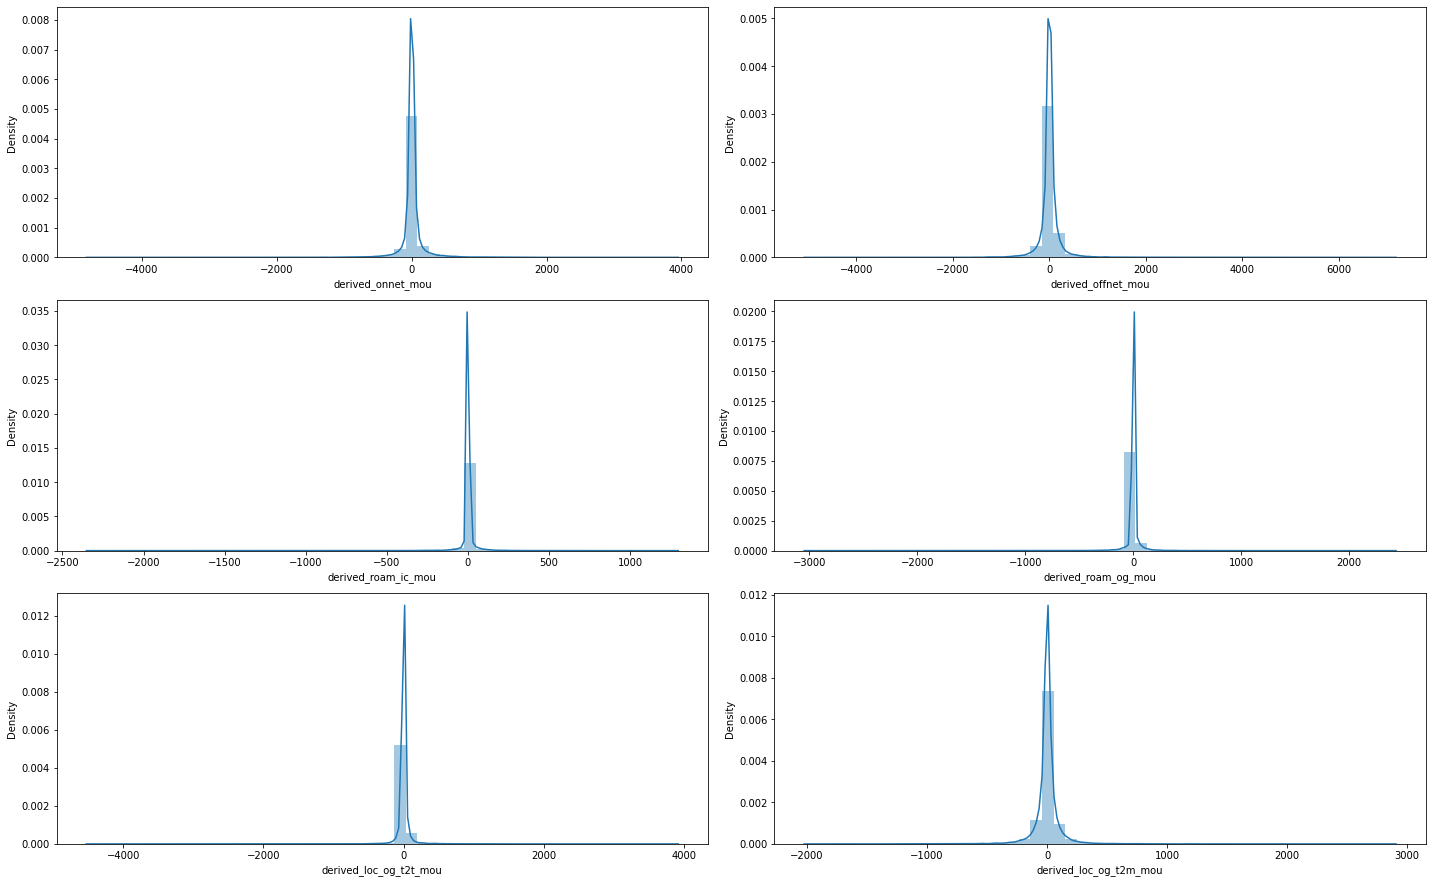

In [42]:
generate_distribution_plot(feature_list)

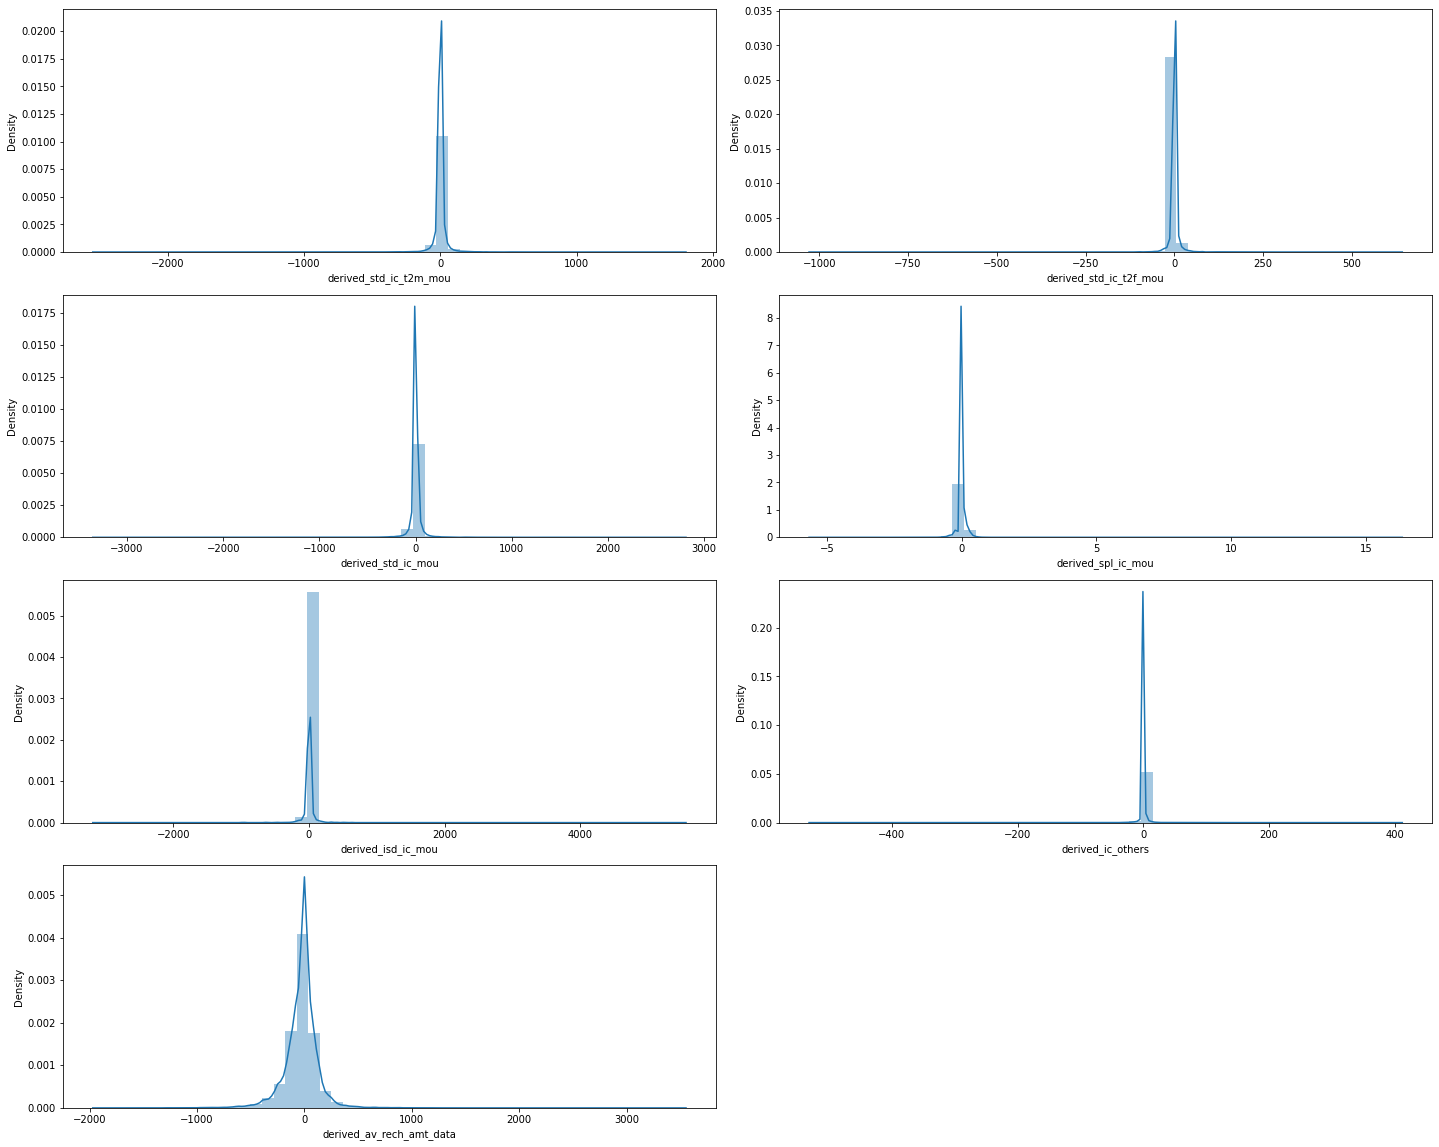

In [43]:
feature_list = ['derived_std_ic_t2m_mou','derived_std_ic_t2f_mou','derived_std_ic_mou','derived_spl_ic_mou','derived_isd_ic_mou','derived_ic_others','derived_av_rech_amt_data']
generate_distribution_plot(feature_list)

Since most of the features are seen to highly skewed imputing 'mode' value in place of missing data.

In [44]:
for feat in feat_with_missing_value:
    High_value_customers[feat] = High_value_customers[feat].fillna(High_value_customers[feat].mode()[0])

In [45]:
# Verifying the features after Missing value Imputation
High_value_customers[feat_with_missing_value].isnull().sum()

derived_onnet_mou           0
derived_offnet_mou          0
derived_roam_ic_mou         0
derived_roam_og_mou         0
derived_loc_og_t2t_mou      0
derived_loc_og_t2m_mou      0
derived_loc_og_t2f_mou      0
derived_loc_og_t2c_mou      0
derived_loc_og_mou          0
derived_std_og_t2t_mou      0
derived_std_og_t2m_mou      0
derived_std_og_t2f_mou      0
derived_std_og_mou          0
derived_isd_og_mou          0
derived_spl_og_mou          0
derived_og_others           0
derived_loc_ic_t2t_mou      0
derived_loc_ic_t2m_mou      0
derived_loc_ic_t2f_mou      0
derived_loc_ic_mou          0
derived_std_ic_t2t_mou      0
derived_std_ic_t2m_mou      0
derived_std_ic_t2f_mou      0
derived_std_ic_mou          0
derived_spl_ic_mou          0
derived_isd_ic_mou          0
derived_ic_others           0
derived_av_rech_amt_data    0
dtype: int64

## Outlier Treatment

In [46]:
len(High_value_customers.columns)

46

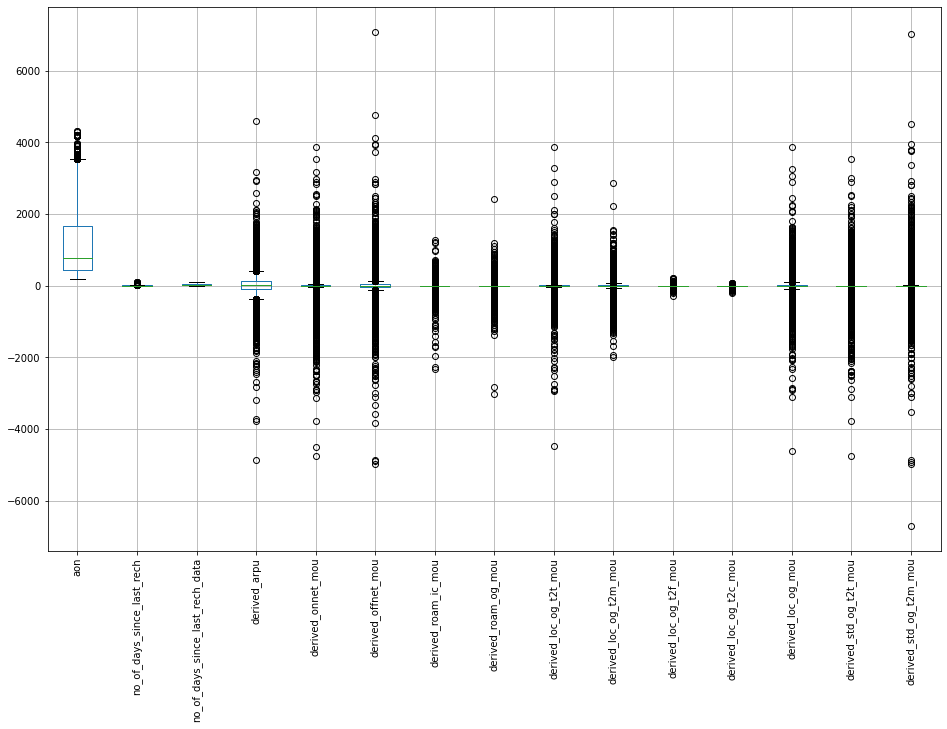

In [47]:
plt.figure(figsize = (16,10)) 
High_value_customers.iloc[:,:15].boxplot()
plt.xticks(rotation=90)
plt.show()

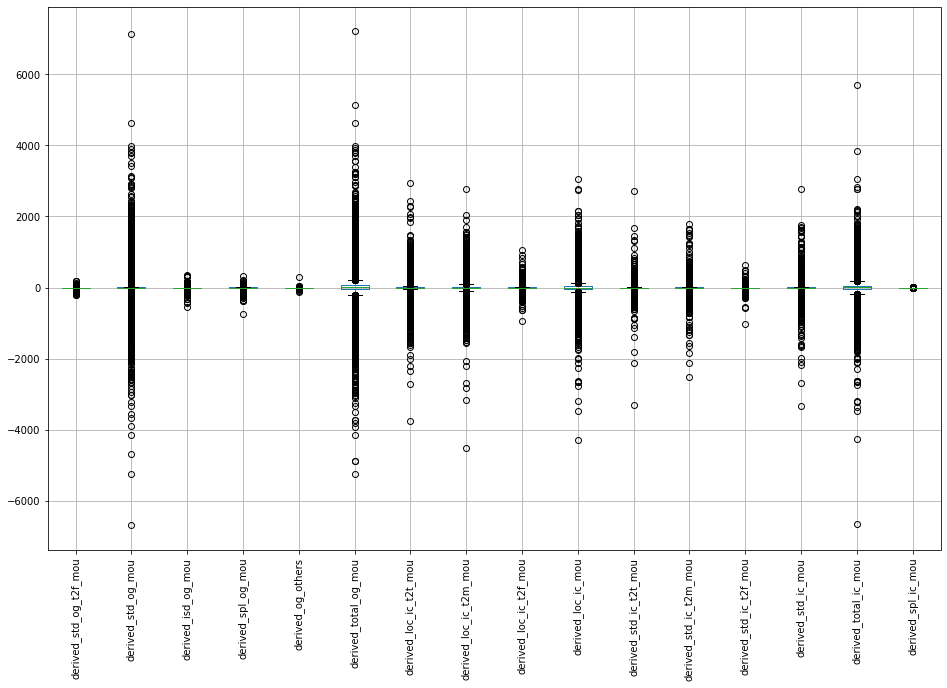

In [48]:
plt.figure(figsize = (16,10)) 
High_value_customers.iloc[:,15:31].boxplot()
plt.xticks(rotation=90)
plt.show()

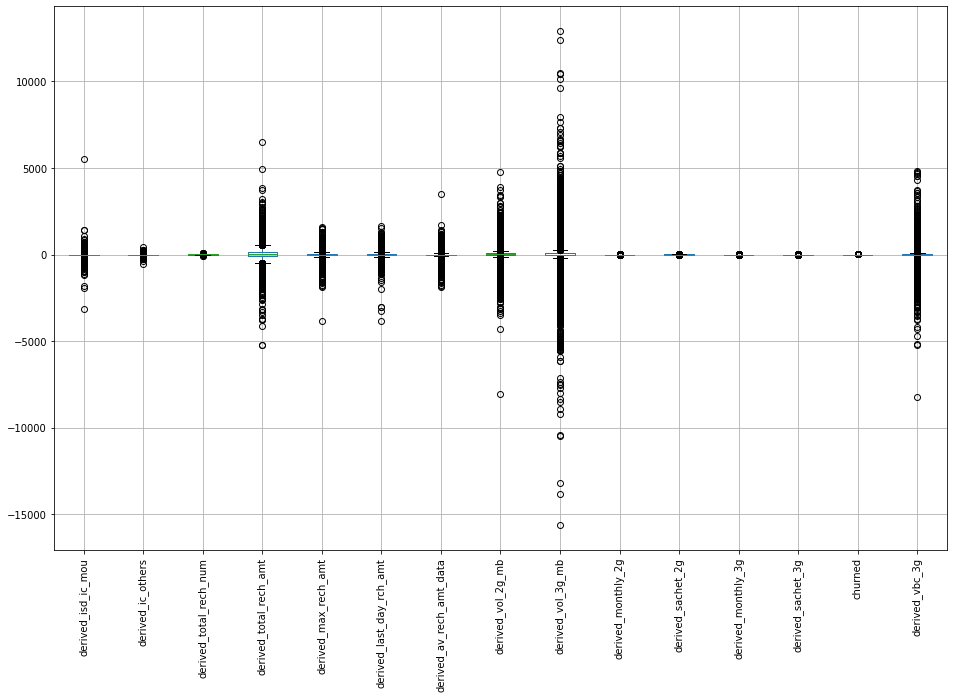

In [49]:
plt.figure(figsize = (16,10)) 
High_value_customers.iloc[:,31:].boxplot()
plt.xticks(rotation=90)
plt.show()

Most of the features have high number of outliers, dropping the outliers will cause loss of information. Hence capping and flooring the extreme values.

In [50]:
for x in High_value_customers.drop(['churned'],axis=1).columns: # Excluding target column ie churned
    Q1 = High_value_customers[x].quantile(0.25)
    Q3 = High_value_customers[x].quantile(0.75)
    IQR = Q3 - Q1
    High_value_customers[x].loc[(High_value_customers[x] < (Q1 - 1.5 * IQR))]= Q1 - 1.5 * IQR
    High_value_customers[x].loc[(High_value_customers[x] > (Q3 + 1.5 * IQR))]= Q3 + 1.5 * IQR

## Checking Correlation

In [51]:
first_half = High_value_customers.columns[:23]
first_half = first_half.append(High_value_customers.columns[-2:-1]) # including 'churned column'
first_half

Index(['aon', 'no_of_days_since_last_rech', 'no_of_days_since_last_rech_data',
       'derived_arpu', 'derived_onnet_mou', 'derived_offnet_mou',
       'derived_roam_ic_mou', 'derived_roam_og_mou', 'derived_loc_og_t2t_mou',
       'derived_loc_og_t2m_mou', 'derived_loc_og_t2f_mou',
       'derived_loc_og_t2c_mou', 'derived_loc_og_mou',
       'derived_std_og_t2t_mou', 'derived_std_og_t2m_mou',
       'derived_std_og_t2f_mou', 'derived_std_og_mou', 'derived_isd_og_mou',
       'derived_spl_og_mou', 'derived_og_others', 'derived_total_og_mou',
       'derived_loc_ic_t2t_mou', 'derived_loc_ic_t2m_mou', 'churned'],
      dtype='object')

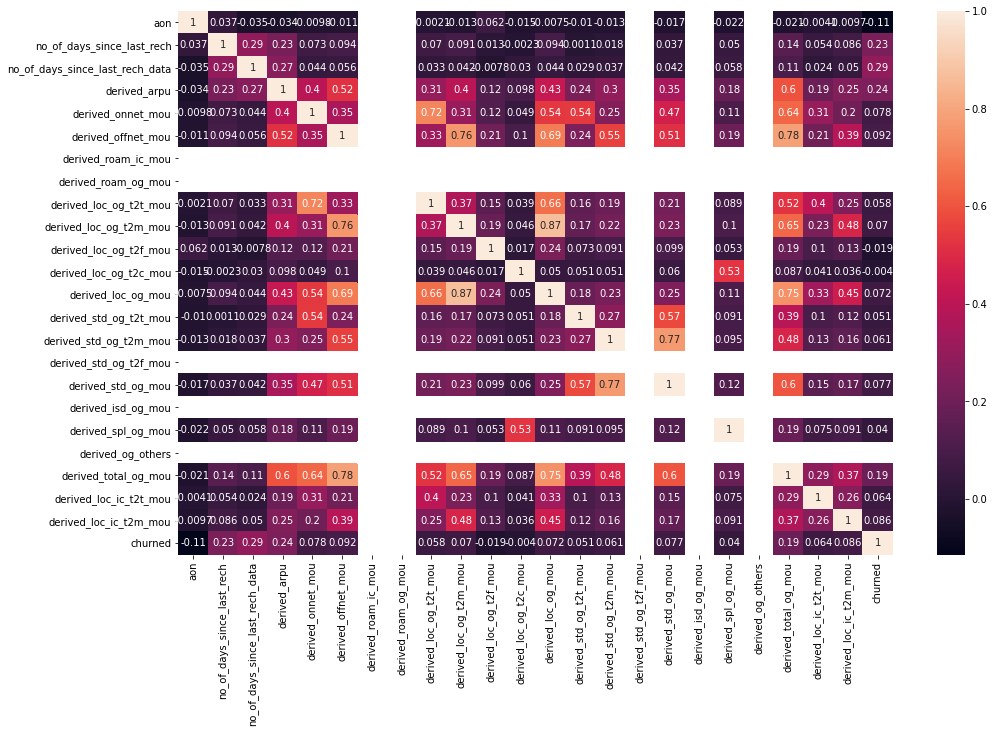

In [52]:
# Plotting correlation between first 23 features and 'churned'

plt.figure(figsize = (16,10))
sns.heatmap(High_value_customers[first_half].corr(),annot = True)
plt.show()

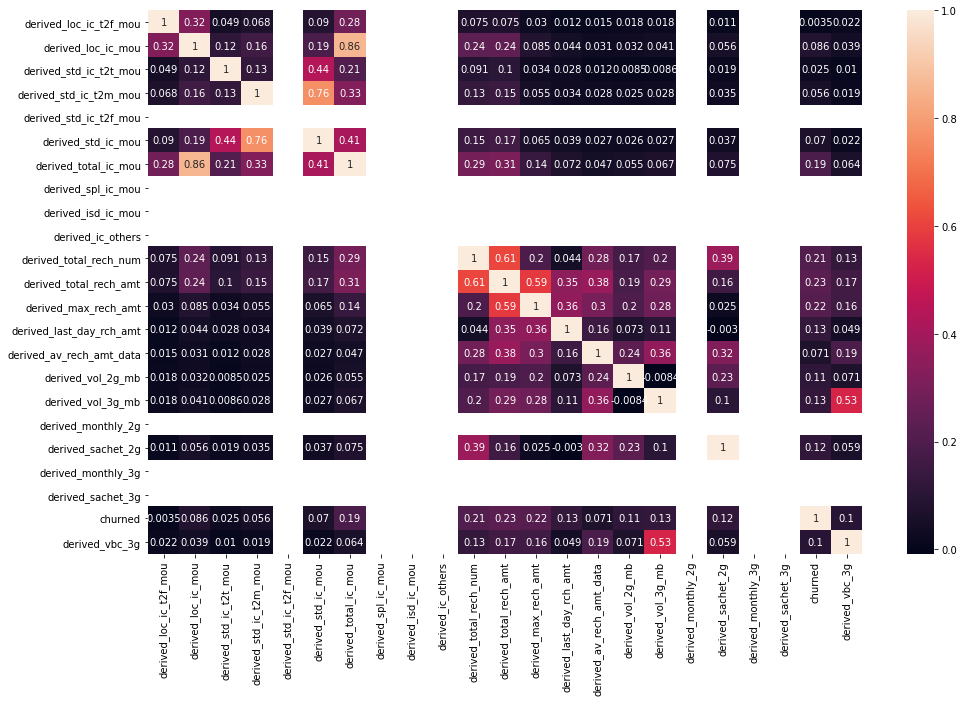

In [53]:
# Plotting correlation between remaining features and 'churned'

plt.figure(figsize = (16,10))
sns.heatmap(High_value_customers.iloc[:,23:].corr(),annot = True)
plt.show()

In [54]:
# After Outlier Treatment some features have no variance
# Identifying features having fixed values in all rows and removing them

skewed= []
for x in High_value_customers.columns:
    if len(High_value_customers[x].value_counts())==1:
        skewed.append(x)
        print(High_value_customers[x].value_counts())
print(skewed)

High_value_customers.drop(skewed,axis=1,inplace=True)

0.0    30378
Name: derived_roam_ic_mou, dtype: int64
0.0    30378
Name: derived_roam_og_mou, dtype: int64
0.0    30378
Name: derived_std_og_t2f_mou, dtype: int64
0.0    30378
Name: derived_isd_og_mou, dtype: int64
0.0    30378
Name: derived_og_others, dtype: int64
0.0    30378
Name: derived_std_ic_t2f_mou, dtype: int64
0.0    30378
Name: derived_spl_ic_mou, dtype: int64
0.0    30378
Name: derived_isd_ic_mou, dtype: int64
0.0    30378
Name: derived_ic_others, dtype: int64
0.0    30378
Name: derived_monthly_2g, dtype: int64
0.0    30378
Name: derived_monthly_3g, dtype: int64
0.0    30378
Name: derived_sachet_3g, dtype: int64
['derived_roam_ic_mou', 'derived_roam_og_mou', 'derived_std_og_t2f_mou', 'derived_isd_og_mou', 'derived_og_others', 'derived_std_ic_t2f_mou', 'derived_spl_ic_mou', 'derived_isd_ic_mou', 'derived_ic_others', 'derived_monthly_2g', 'derived_monthly_3g', 'derived_sachet_3g']


## Bivariate and Multivariate Analysis

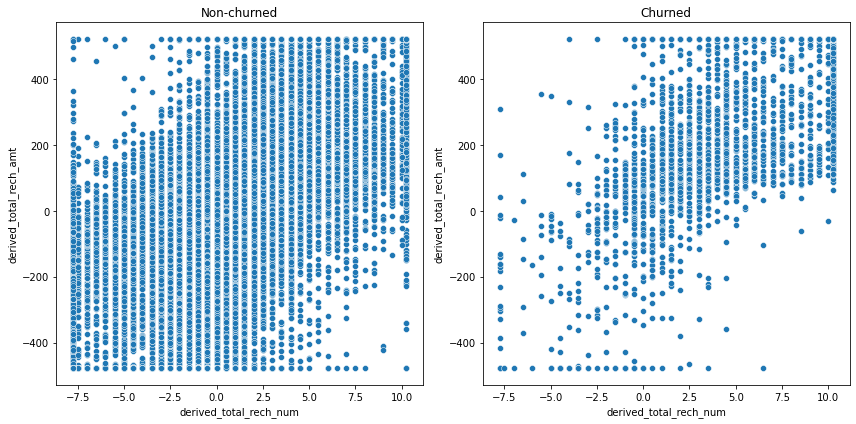

In [55]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-churned")
ax2 = fig.add_subplot(1, 2, 2, title="Churned")

sns.scatterplot(High_value_customers[High_value_customers["churned"] == 0]['derived_total_rech_num'], High_value_customers[High_value_customers["churned"] == 0]['derived_total_rech_amt'], ax=ax1)
sns.scatterplot(High_value_customers[High_value_customers["churned"] == 1]['derived_total_rech_num'], High_value_customers[High_value_customers["churned"] == 1]['derived_total_rech_amt'], ax=ax2)

plt.tight_layout()
plt.show()

**Observation:**

- There is a positive correlation between total recharge amount and total number of recharges.
- 'derived_total_rech_amt' is derived by taking average of total recharge done in good phase (i.e. month 6 and 7) and deducting recharge of action phase (month 8) from it. 
- A positive value of this feature means, recharge amount value dropped from good phase to action phase. The same applies for 'derived_total_rech_num' as well.
- A negative value of this feature means, recharge amount value increased from good phase to action phase. The same applies for 'derived_total_rech_num' as well.
- By comparing churned and non-churned customer we can see that, for churned customers both recharge number and recharge amount have dropped in action phase.  


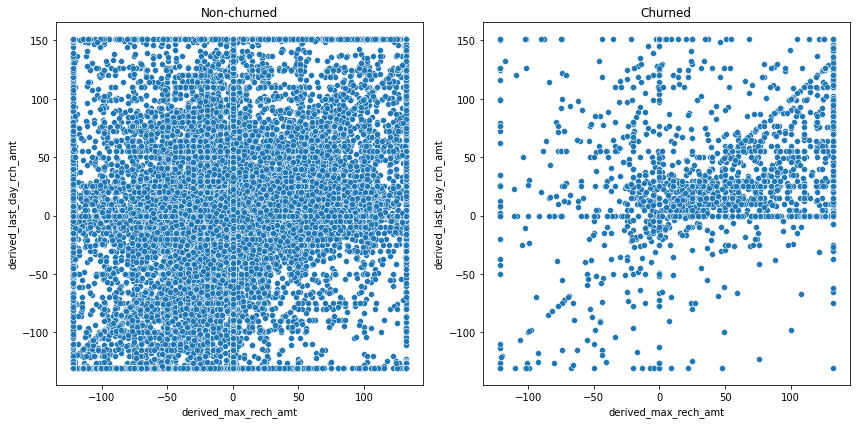

In [56]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-churned")
ax2 = fig.add_subplot(1, 2, 2, title="Churned")

sns.scatterplot(High_value_customers[High_value_customers["churned"] == 0]['derived_max_rech_amt'], High_value_customers[High_value_customers["churned"] == 0]['derived_last_day_rch_amt'], ax=ax1)
sns.scatterplot(High_value_customers[High_value_customers["churned"] == 1]['derived_max_rech_amt'], High_value_customers[High_value_customers["churned"] == 1]['derived_last_day_rch_amt'], ax=ax2)

plt.tight_layout()
plt.show()

**Observation:**

- derived_max_rech_amt and derive_last_day_rch_amt are most likely to be positive for churned customers. This means, drop in maximum recharge amount and last day recharge amount in action phase can signify customer churn.

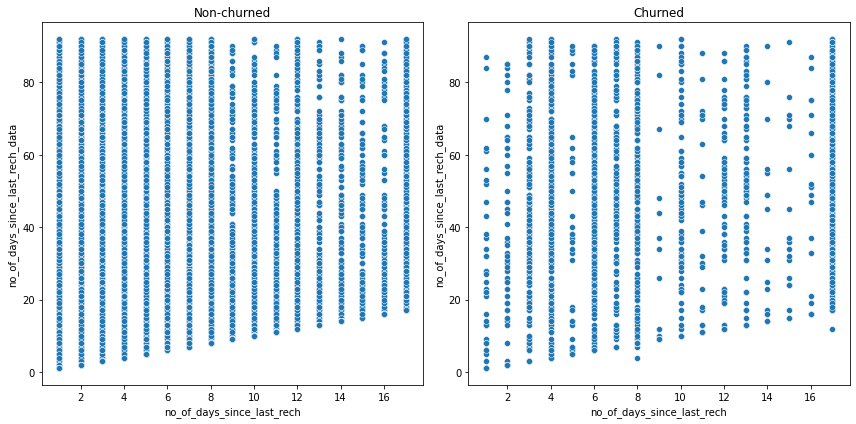

In [57]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-churned")
ax2 = fig.add_subplot(1, 2, 2, title="Churned")

sns.scatterplot(High_value_customers[High_value_customers["churned"] == 0]['no_of_days_since_last_rech'], High_value_customers[High_value_customers["churned"] == 0]['no_of_days_since_last_rech_data'], ax=ax1)
sns.scatterplot(High_value_customers[High_value_customers["churned"] == 1]['no_of_days_since_last_rech'], High_value_customers[High_value_customers["churned"] == 1]['no_of_days_since_last_rech_data'], ax=ax2)

plt.tight_layout()
plt.show()

In [58]:
print("Non-churned Customers")
print(High_value_customers[High_value_customers["churned"] == 0]['no_of_days_since_last_rech'].value_counts(normalize=True))
#print(High_value_customers[High_value_customers["churned"] == 0]['no_of_days_since_last_rech_data'].value_counts(normalize=True))

print("Churned Customers")
print(High_value_customers[High_value_customers["churned"] == 1]['no_of_days_since_last_rech'].value_counts(normalize=True))
#print(High_value_customers[High_value_customers["churned"] == 1]['no_of_days_since_last_rech_data'].value_counts(normalize=True))

Non-churned Customers
1.0     0.163461
2.0     0.136169
3.0     0.108842
4.0     0.104743
6.0     0.091726
17.0    0.081479
7.0     0.074323
5.0     0.064111
8.0     0.063680
12.0    0.019129
10.0    0.019093
9.0     0.018554
11.0    0.014491
13.0    0.014059
14.0    0.010535
15.0    0.007911
16.0    0.007695
Name: no_of_days_since_last_rech, dtype: float64
Churned Customers
17.0    0.316712
6.0     0.156213
4.0     0.104012
8.0     0.082587
7.0     0.073627
3.0     0.068952
13.0    0.037398
10.0    0.034671
12.0    0.025711
2.0     0.022984
1.0     0.021815
5.0     0.016362
11.0    0.009349
16.0    0.008570
15.0    0.007402
9.0     0.007012
14.0    0.006623
Name: no_of_days_since_last_rech, dtype: float64


**Observation:**

- The above 2 features are extracted by counting the number of days between last recharge date available (in June, July or August) and 1st September of the same year.

- By comparing Churned and non-churned customers, customers who have not recharged in 17 days or more are highly likely to churn. About 32 % of the churne customers did their last recharge 17 days ago. On the other hand, 8% of the non-churned customers did their last recharge 17 days ago (from reference date of 1st September).

- Number of days since last recharge is likely to be low for non-churned customer.

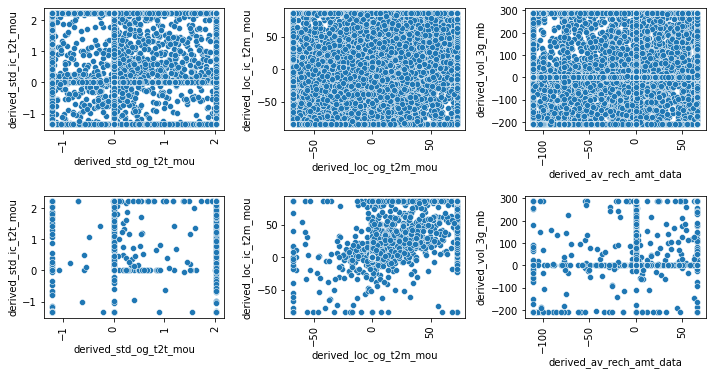

In [59]:
# Checking for correlation between minute of usage of std and local calls for customers and comparing between churned and non-churned customers
# Checking if there is any visible trend in recharge amount for the churned customers.

feature_pair = [['derived_std_og_t2t_mou','derived_std_ic_t2t_mou'], ['derived_loc_og_t2m_mou', 'derived_loc_ic_t2m_mou'], ['derived_av_rech_amt_data','derived_vol_3g_mb']]

fig=plt.subplots(figsize=(10, 10))

for i, feats in enumerate(feature_pair+feature_pair):
    if i < 3:
        churned=0 # first row for non-churned
    else:
        churned=1 # second row for churned
    plt.subplot(4, 3, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.scatterplot(x=High_value_customers[High_value_customers["churned"] == churned][feats[0]], y=High_value_customers[High_value_customers["churned"] == churned][feats[1]])
    plt.xticks(rotation=90)
    plt.tight_layout()

**Observation:**
- There is no conclusive trend visible for churned and non-churned customers for the above features.

## Splitting Data into Training and Test set

In [60]:
X = High_value_customers.drop(['churned'], axis=1)
y = High_value_customers[['churned']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [61]:
High_value_customers.shape

(30378, 34)

In [62]:
print("shape of X_train ", X_train.shape)
print("shape of X_test ", X_test.shape)
print("shape of y_train ", y_train.shape)
print("shape of y_test ", y_test.shape)

shape of X_train  (24302, 33)
shape of X_test  (6076, 33)
shape of y_train  (24302, 1)
shape of y_test  (6076, 1)


## Feature Scaling

In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Data Imbalance Treatment

In [64]:
print("Before Data Imbalance Treatment: ")
print("X train scaled shape : ", X_train_scaled.shape)
print("y train shape : ", y_train.shape)
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train_scaled,y_train)
print("After Data Imbalance Treatment: ")
print("X train shape : ", X_train_smote.shape)
print("y train shape : ", y_train_smote.shape)

Before Data Imbalance Treatment: 
X train scaled shape :  (24302, 33)
y train shape :  (24302, 1)
After Data Imbalance Treatment: 
X train shape :  (44528, 33)
y train shape :  (44528,)


- For building predictor model (where predicting churn is more important than model interpreatability), dimensionality reduction technique PCA will be applied on Independent variables.
- For identifying most significant driving factors of churn, X_train_scaled will be used. 

# Applying PCA and Building Predictor Model

In [65]:
def evaluate_model(y_true, y_pred):
    confusion = metrics.confusion_matrix(y_true, y_pred)
    TP = confusion[1,1] 
    TN = confusion[0,0] 
    FP = confusion[0,1] 
    FN = confusion[1,0] 

    accuracy_sc = metrics.accuracy_score(y_true, y_pred)
    sensitivity_score = TP / float(TP+FN)
    return accuracy_sc, sensitivity_score

## Logistic Regression

Using Logistic Regression Model as the base model. 

- Performing PCA for component numbers 10,15,20,25,30
- Peforming Logistic Regression with different number features and different number of cutoffs 0.2,0.3,0.4,0.5,0.6,0.7,0.8
- Storing the acuracy score and sensitivity scores of the models on test data in 2 different dataframes.
- This will help in finding out optimim number of features (for PCA) and cut off value (for Logistic Regression)

In [66]:
accuracy_test_data = pd.DataFrame(data=np.zeros((7,5)),index=[0.2,0.3,0.4,0.5,0.6,0.7,0.8], columns=[10,15,20,25,30])
sensitivity_test_data = pd.DataFrame(data=np.zeros((7,5)),index=[0.2,0.3,0.4,0.5,0.6,0.7,0.8], columns=[10,15,20,25,30])

In [67]:
for n in [10,15,20,25,30]:
    pca = IncrementalPCA(n_components=n)    
    X_train_pca = pca.fit_transform(X_train_smote) # training data is scaled and treated for data imbalance
    X_test_pca = pca.transform(X_test_scaled)      # test data is only scaled
      
    X_train_sm = sm.add_constant(X_train_pca)
    X_test_sm = sm.add_constant(X_test_pca)
    logm2 = sm.GLM(y_train_smote,X_train_sm, family = sm.families.Binomial())
    res = logm2.fit()

    #y_train_pred = res.predict(X_train_sm)
    y_test_pred = res.predict(X_test_sm)

    df = pd.DataFrame()
    df['true_value'] = y_test.values.reshape(-1)
    df['pred_prob_value'] = y_test_pred.reshape(-1) # predicted probability of churned

    for cutoff in [float(x)/10 for x in range(2, 9)]:
        col_name = 'pred_value' + str(cutoff)
        df[col_name] = df['pred_prob_value'].map(lambda x: 1 if x > cutoff else 0)
        accuracy_test_data.loc[cutoff, n], sensitivity_test_data.loc[cutoff, n] = evaluate_model(y_test, df[col_name])

In [68]:
df.head(5)

,true_value,pred_prob_value,pred_value0.2,pred_value0.3,pred_value0.4,pred_value0.5,pred_value0.6,pred_value0.7,pred_value0.8
0,0,0.089363,0,0,0,0,0,0,0
1,0,0.348835,1,1,0,0,0,0,0
2,1,0.964095,1,1,1,1,1,1,1
3,0,0.363681,1,1,0,0,0,0,0
4,0,0.888833,1,1,1,1,1,1,1


In [69]:
sensitivity_test_data

,10,15,20,25,30
0.2,0.933837,0.933837,0.933837,0.931947,0.935728
0.3,0.873346,0.871456,0.869565,0.882798,0.880907
0.4,0.822306,0.829868,0.844991,0.843100,0.846881
0.5,0.763705,0.771267,0.773157,0.771267,0.773157
0.6,0.710775,0.705104,0.705104,0.703214,0.701323
0.7,0.612476,0.604915,0.614367,0.629490,0.635161
0.8,0.444234,0.461248,0.470699,0.506616,0.500945


In [70]:
accuracy_test_data

,10,15,20,25,30
0.2,0.486175,0.504279,0.531106,0.528637,0.532093
0.3,0.616853,0.634299,0.644997,0.650099,0.650428
0.4,0.713134,0.722186,0.736011,0.735846,0.740454
0.5,0.782752,0.789500,0.797729,0.798058,0.800033
0.6,0.838874,0.839697,0.844470,0.848420,0.847433
0.7,0.880184,0.878868,0.881336,0.884793,0.886109
0.8,0.907176,0.906188,0.906188,0.911619,0.911455


After inspecting accuracy score and sensitivity score for different number of principal components and cut off , taking 15 components and cutoff=0.4

In [71]:
pca = IncrementalPCA(n_components=15)    
X_train_pca = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test_scaled)

In [72]:
evaluation_df = pd.DataFrame(data=np.zeros((4,2)), index=['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'], columns=['Accuracy', 'Sensitivity'])
evaluation_df.loc['Logistic Regression', 'Accuracy'] = round(accuracy_test_data.loc[0.4, 15], 3)
evaluation_df.loc['Logistic Regression', 'Sensitivity'] = round(sensitivity_test_data.loc[0.4, 15],3)
evaluation_df

,Accuracy,Sensitivity
Logistic Regression,0.722,0.83
Decision Tree,0.000,0.00
Random Forest,0.000,0.00
XGBoost,0.000,0.00


- Since the main objective is to predict as much potential churn as possible, we will be focusing on sensitivity for model evaluation.
- With GridSearchCV finding tuning the hyperparameters and obtaining the best estimator


## Decision Tree

In [73]:
dt = DecisionTreeClassifier(random_state=101)
params = {
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [5, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "recall")
grid_search.fit(X_train_pca, y_train_smote)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   38.9s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=101,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                      

In [74]:
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5}

In [75]:
dt_best = grid_search.best_estimator_
dt_best.fit(X_train_pca, y_train_smote)
y_train_pred_dt = dt_best.predict(X_train_pca)
y_test_pred_dt = dt_best.predict(X_test_pca)
print(y_test_pred_dt)

[0 0 1 ... 0 0 0]


In [76]:
print("Performance of Decision Tree Classifier on training data")
accuracy_sc, sensitivity_score = evaluate_model(y_train_smote, y_train_pred_dt)
print("Accuracy : ", accuracy_sc)
print("Sensitivity : ", sensitivity_score)

print("Performance of Decision Tree Classifier on test data")
accuracy_sc, sensitivity_score = evaluate_model(y_test, y_test_pred_dt)
evaluation_df.loc['Decision Tree', 'Accuracy'] = accuracy_sc
evaluation_df.loc['Decision Tree', 'Sensitivity'] = sensitivity_score
evaluation_df

Performance of Decision Tree Classifier on training data
Accuracy :  0.9551293568091987
Sensitivity :  0.9704455623427956
Performance of Decision Tree Classifier on test data


,Accuracy,Sensitivity
Logistic Regression,0.722000,0.830000
Decision Tree,0.844964,0.644612
Random Forest,0.000000,0.000000
XGBoost,0.000000,0.000000


## Random Forest

In [77]:
classifier_rf = RandomForestClassifier(random_state=101, n_jobs=-1)

params = {
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [5, 20, 50],
    'max_features': [3, 4, 5],
    'n_estimators': [50, 100]
}

grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=3, n_jobs=-1, verbose=1, scoring = "recall")
						
grid_search.fit(X_train_pca,y_train_smote)
rf_best = grid_search.best_estimator_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 18.1min finished


In [78]:
grid_search.best_params_

{'max_depth': 20,
 'max_features': 5,
 'min_samples_leaf': 5,
 'n_estimators': 100}

In [79]:
rf_best.fit(X_train_pca, y_train_smote)
y_train_pred_rf = rf_best.predict(X_train_pca)
y_test_pred_rf = rf_best.predict(X_test_pca)
print(y_test_pred_rf)

[0 0 1 ... 0 0 0]


In [80]:
print("Performance of Random Forest Classifier on training data")
accuracy_sc, sensitivity_score = evaluate_model(y_train_smote, y_train_pred_rf)
print("Accuracy : ", accuracy_sc)
print("Sensitivity : ", sensitivity_score)

print("Performance of Random Forest Classifier on test data")
accuracy_sc,sensitivity_score = evaluate_model(y_test, y_test_pred_rf)
evaluation_df.loc['Random Forest', 'Accuracy'] = round(accuracy_sc, 5)
evaluation_df.loc['Random Forest', 'Sensitivity'] = round(sensitivity_score, 5)
evaluation_df

Performance of Random Forest Classifier on training data
Accuracy :  0.9705578512396694
Sensitivity :  0.9865253323751347
Performance of Random Forest Classifier on test data


,Accuracy,Sensitivity
Logistic Regression,0.722000,0.830000
Decision Tree,0.844964,0.644612
Random Forest,0.897140,0.657840
XGBoost,0.000000,0.000000


Both Decision and Random Forest classifier models performed far worse on test data. We are focusing on models performance on test data for choosing the final model, as the final model should be good at generalizing the underlying trend in data.

## XGBoost

In [81]:
xgclf = xgb.XGBClassifier()

parameters = {'learning_rate': [0.2, 0.3, 0.4],
              'max_depth': [10, 20],
              'n_estimators': [100, 200, 500]}

clf_xgb = GridSearchCV(estimator=xgclf,
                      param_grid=parameters,
                      n_jobs=-1,
                      cv=3,
                      scoring='recall',
                      verbose=1,
                      refit=True)

clf_xgb.fit(X_train_pca, y_train_smote)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 26.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.3, 0.4],
                         'max_depth': [10, 20],
                         'n_estimators': [100, 200, 500]},
             

In [82]:
clf_xgb.best_params_

{'learning_rate': 0.4, 'max_depth': 10, 'n_estimators': 500}

In [83]:
xgb_best = clf_xgb.best_estimator_

xgb_best.fit(X_train_pca, y_train_smote)
y_train_pred_xgb = xgb_best.predict(X_train_pca)
y_test_pred_xgb = xgb_best.predict(X_test_pca)
print(y_test_pred_xgb)

[0 0 1 ... 0 0 0]


In [84]:
print("Performance of XGBoost Classifier on training data")
accuracy_sc, sensitivity_score = evaluate_model(y_train_smote, y_train_pred_xgb)
print("Accuracy : ", accuracy_sc)
print("Sensitivity : ", sensitivity_score)

print("Performance of XGBoost Classifier on test data")
accuracy_sc, sensitivity_score = evaluate_model(y_test, y_test_pred_xgb)
evaluation_df.loc['XGBoost', 'Accuracy'] = round(accuracy_sc, 5)
evaluation_df.loc['XGBoost', 'Sensitivity'] = round(sensitivity_score, 5)
evaluation_df

Performance of XGBoost Classifier on training data
Accuracy :  1.0
Sensitivity :  1.0
Performance of XGBoost Classifier on test data


,Accuracy,Sensitivity
Logistic Regression,0.722000,0.830000
Decision Tree,0.844964,0.644612
Random Forest,0.897140,0.657840
XGBoost,0.907180,0.601130


- After comparing the accuracy and sentivity score on test data of different models like Logistic Regression, Decision Tree Classifier, Random Forest Classifier and XGBoost, it is observed that,

- **Logistic Regression has highest sensitivity score and lowest accuracy score.**

- In this particular scenario, it is important predict as much potential churn as possible to make business strategies to reduce the churn. Hence Sensitivity is considered over accuracy and other evaluation metrics.

- Logistice Regression model with cutoff=0.4 and 15 principal components has achieved 0.83 sensitivity on test data which means it is able to predict 83% of the total churned cases on unseen data.

## Building Final Predictor Model

In [85]:
# Optimizing Logistic Regression Model further
# Calculating accuracy and sensitivity for  probability cutoffs [0.25, 0.26, 0.27, ... , 0.5]

performance_df = pd.DataFrame(columns = ['proba_score','accuracy_score','sensitivity_score'])
pca = IncrementalPCA(n_components=15)    
X_train_pca = pca.fit_transform(X_train_smote) # training data is scaled and treated for data imbalance
X_test_pca = pca.transform(X_test_scaled)      # test data is only scaled

# Training Logistic Regression Model for getting Churn Probability
X_train_sm = sm.add_constant(X_train_pca)
X_test_sm = sm.add_constant(X_test_pca)
logm2 = sm.GLM(y_train_smote,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()

#y_train_pred = res.predict(X_train_sm)
y_test_pred = res.predict(X_test_sm)

df = pd.DataFrame()
df['true_value'] = y_test.values.reshape(-1)      # churned value
df['pred_prob_value'] = y_test_pred.reshape(-1)   # predicted churned probability

# The predicted churned probability remain fixed as no change in training data and model hyperpameters.
# The predicted churned label (0 or 1) changes with change in cut-off

for cutoff in [float(x)/100 for x in range(25, 50)]:
    col_name = 'pred_value_' + str(cutoff)
    df[col_name] = df['pred_prob_value'].map(lambda x: 1 if x > cutoff else 0) # Predicted churned based on cutoff value
    performance_df.loc[cutoff, 'proba_score'] = cutoff
    performance_df.loc[cutoff, 'accuracy_score'], performance_df.loc[cutoff, 'sensitivity_score'] = evaluate_model(y_test, df[col_name])

In [86]:
df.head(5)

,true_value,pred_prob_value,pred_value_0.25,pred_value_0.26,pred_value_0.27,pred_value_0.28,pred_value_0.29,pred_value_0.3,pred_value_0.31,pred_value_0.32,pred_value_0.33,pred_value_0.34,pred_value_0.35,pred_value_0.36,pred_value_0.37,pred_value_0.38,pred_value_0.39,pred_value_0.4,pred_value_0.41,pred_value_0.42,pred_value_0.43,pred_value_0.44,pred_value_0.45,pred_value_0.46,pred_value_0.47,pred_value_0.48,pred_value_0.49
0,0,0.213824,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0.436250,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0
2,1,0.909333,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,0,0.372553,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0.860911,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [87]:
performance_df

,proba_score,accuracy_score,sensitivity_score
0.25,0.25,0.574062,0.907372
0.26,0.26,0.587228,0.903592
0.27,0.27,0.599737,0.89225
0.28,0.28,0.613726,0.884688
0.29,0.29,0.623272,0.880907
0.30,0.3,0.634299,0.871456
0.31,0.31,0.645326,0.865784
0.32,0.32,0.654378,0.860113
0.33,0.33,0.664088,0.856333
0.34,0.34,0.672811,0.848771


By inspecting performance metrics of logistric regression model for different cutoff values between 0.21 to 0.5, we are selecting 0.41 as the cutoff for final model as it has accuracy score of 0.74 and sensitivity score of 0.82


- **Final Predictor Model = Logistic Regression**
- **No. of principal = 15**
- **Probability Cutoff = 0.42**


# Feature Selection for Building Interpretable Model

- Starting with RFE to identify top 20 features first
- Then manually inspecting p-values and VIF to improvise the model further.
- Logistic Regression model has good interpretability, also Logistic Regression model performed better with respect to sensitivity.

### Using RFE for Identifying top 20 features

In [88]:
# X_train_scaled is scaled. However its a Numpy array.
# To retain the column names, creating a dataframe with columns of X and values of X_train_scaled 

X_tr_scaled_df = pd.DataFrame(data=X_train_scaled, columns= X.columns)

logreg = LogisticRegression()
rfe = RFE(logreg, 20)             
rfe = rfe.fit(X_tr_scaled_df, y_train)

print(list(zip(X_tr_scaled_df.columns, rfe.support_, rfe.ranking_)))

[('aon', True, 1), ('no_of_days_since_last_rech', True, 1), ('no_of_days_since_last_rech_data', True, 1), ('derived_arpu', True, 1), ('derived_onnet_mou', True, 1), ('derived_offnet_mou', True, 1), ('derived_loc_og_t2t_mou', False, 7), ('derived_loc_og_t2m_mou', False, 4), ('derived_loc_og_t2f_mou', True, 1), ('derived_loc_og_t2c_mou', False, 3), ('derived_loc_og_mou', True, 1), ('derived_std_og_t2t_mou', False, 8), ('derived_std_og_t2m_mou', False, 11), ('derived_std_og_mou', False, 5), ('derived_spl_og_mou', False, 12), ('derived_total_og_mou', True, 1), ('derived_loc_ic_t2t_mou', True, 1), ('derived_loc_ic_t2m_mou', True, 1), ('derived_loc_ic_t2f_mou', False, 10), ('derived_loc_ic_mou', True, 1), ('derived_std_ic_t2t_mou', False, 9), ('derived_std_ic_t2m_mou', False, 14), ('derived_std_ic_mou', False, 13), ('derived_total_ic_mou', True, 1), ('derived_total_rech_num', True, 1), ('derived_total_rech_amt', False, 2), ('derived_max_rech_amt', True, 1), ('derived_last_day_rch_amt', True,

In [89]:
def build_lr_model(X, y):
    X = sm.add_constant(X)
    logm2 = sm.GLM(y, X, family = sm.families.Binomial())
    res = logm2.fit()
    print(res.summary())

def print_vif(X):
    vif = pd.DataFrame(data=X.columns, columns=['Features'])
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

In [90]:
top_20 = X_tr_scaled_df.columns[rfe.support_]
print("Derived Features Dropped by RFE : ", X_tr_scaled_df.columns[~rfe.support_])
print("============================================================")
build_lr_model(X_tr_scaled_df[top_20], y_train.values)
print_vif(X_tr_scaled_df[top_20])

Derived Features Dropped by RFE :  Index(['derived_loc_og_t2t_mou', 'derived_loc_og_t2m_mou',
       'derived_loc_og_t2c_mou', 'derived_std_og_t2t_mou',
       'derived_std_og_t2m_mou', 'derived_std_og_mou', 'derived_spl_og_mou',
       'derived_loc_ic_t2f_mou', 'derived_std_ic_t2t_mou',
       'derived_std_ic_t2m_mou', 'derived_std_ic_mou',
       'derived_total_rech_amt', 'derived_vbc_3g'],
      dtype='object')
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                24302
Model:                            GLM   Df Residuals:                    24281
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4876.6
Date:                Sun, 02 May 2021   Deviance:                       9753.2
Time:                        

In [91]:
# Dropping feature with highest VIF Value > 2.5
top_19=top_20.drop('derived_loc_ic_mou')
build_lr_model(X_tr_scaled_df[top_19], y_train.values)
print_vif(X_tr_scaled_df[top_19])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                24302
Model:                            GLM   Df Residuals:                    24282
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4909.2
Date:                Sun, 02 May 2021   Deviance:                       9818.4
Time:                        10:29:17   Pearson chi2:                 3.73e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [92]:
# Dropping feature with highest VIF Value > 2.5
top_18=top_19.drop('derived_total_og_mou')
build_lr_model(X_tr_scaled_df[top_18], y_train.values)
print_vif(X_tr_scaled_df[top_18])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                24302
Model:                            GLM   Df Residuals:                    24283
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5004.3
Date:                Sun, 02 May 2021   Deviance:                       10009.
Time:                        10:29:18   Pearson chi2:                 3.25e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [93]:
# Dropping feature with highest p-value > 0.05
top_17=top_18.drop('derived_offnet_mou')
build_lr_model(X_tr_scaled_df[top_17], y_train.values)
print_vif(X_tr_scaled_df[top_17])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                24302
Model:                            GLM   Df Residuals:                    24284
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5004.5
Date:                Sun, 02 May 2021   Deviance:                       10009.
Time:                        10:29:19   Pearson chi2:                 3.25e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [94]:
# Dropping feature with highest p-value > 0.05
top_16=top_17.drop('derived_onnet_mou')
build_lr_model(X_tr_scaled_df[top_16], y_train.values)
print_vif(X_tr_scaled_df[top_16])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                24302
Model:                            GLM   Df Residuals:                    24285
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5004.9
Date:                Sun, 02 May 2021   Deviance:                       10010.
Time:                        10:29:20   Pearson chi2:                 3.25e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [95]:
# Removing feature with highest VIF > 2.5
top_15=top_16.drop('derived_total_ic_mou')
build_lr_model(X_tr_scaled_df[top_15], y_train.values)
print_vif(X_tr_scaled_df[top_15])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                24302
Model:                            GLM   Df Residuals:                    24286
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5143.8
Date:                Sun, 02 May 2021   Deviance:                       10288.
Time:                        10:29:21   Pearson chi2:                 3.15e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

VIF and p-value of the remaining features are in acceptable range. p-value < 0.05 (significance level)

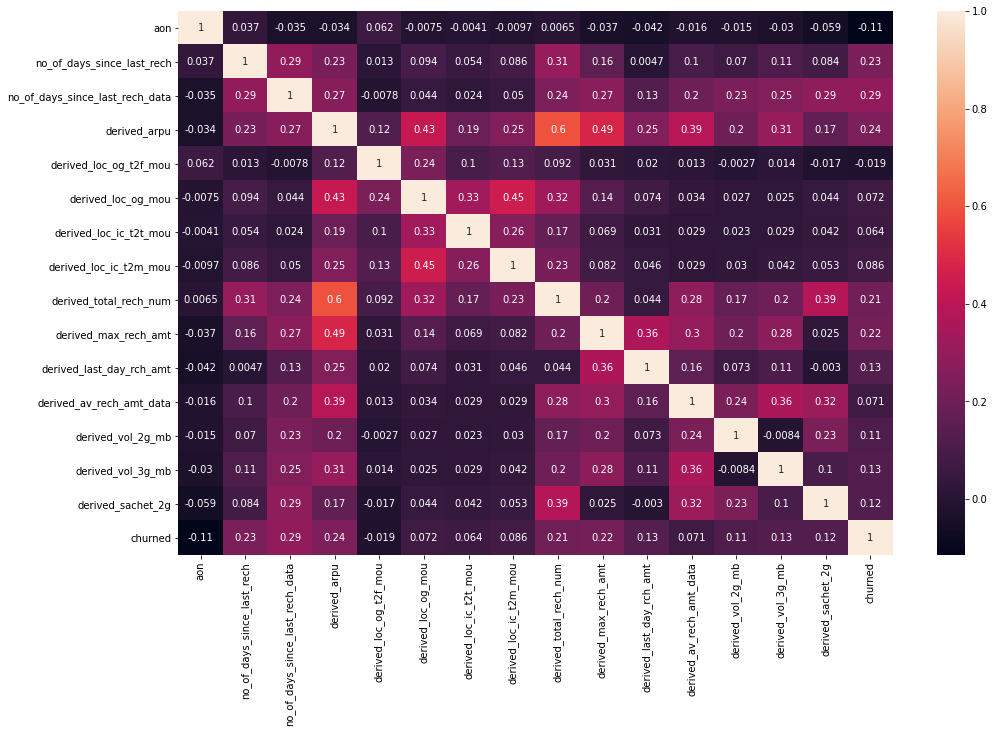

In [96]:
cols = top_15.append(High_value_customers.columns[-2:-1]) # adding churned column

plt.figure(figsize = (16,10))
sns.heatmap(High_value_customers[cols].corr(),annot = True)
plt.show()

### Using Random Forest for Feature Importance

In [97]:
rf_best = RandomForestClassifier(random_state=101, n_jobs=-1,max_depth=20,max_features=4,min_samples_leaf=5,n_estimators=100)

X_tr_smote_df = pd.DataFrame(data=X_train_smote, columns= X.columns)

rf_best.fit(X_tr_smote_df[top_15], y_train_smote)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=101, verbose=0,
                       warm_start=False)

In [98]:
feature_importance_df = pd.DataFrame({
    "Feature Name": X_tr_smote_df[top_15].columns,
    "Importance": rf_best.feature_importances_})

feature_importance_df.sort_values(by="Importance", ascending=False)

,Feature Name,Importance
2,no_of_days_since_last_rech_data,0.189347
7,derived_loc_ic_t2m_mou,0.128729
1,no_of_days_since_last_rech,0.118306
6,derived_loc_ic_t2t_mou,0.092745
9,derived_max_rech_amt,0.089612
3,derived_arpu,0.074427
5,derived_loc_og_mou,0.055516
10,derived_last_day_rch_amt,0.053745
0,aon,0.038908
4,derived_loc_og_t2f_mou,0.031772


In [99]:
print("Top 15 features are : ", feature_importance_df['Feature Name'].values)

Top 15 features are :  ['aon' 'no_of_days_since_last_rech' 'no_of_days_since_last_rech_data'
 'derived_arpu' 'derived_loc_og_t2f_mou' 'derived_loc_og_mou'
 'derived_loc_ic_t2t_mou' 'derived_loc_ic_t2m_mou'
 'derived_total_rech_num' 'derived_max_rech_amt'
 'derived_last_day_rch_amt' 'derived_av_rech_amt_data' 'derived_vol_2g_mb'
 'derived_vol_3g_mb' 'derived_sachet_2g']


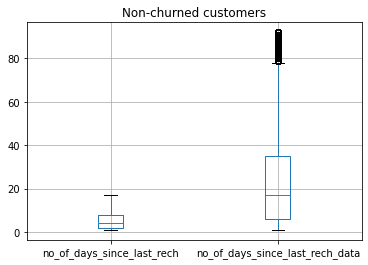

In [100]:
High_value_customers[High_value_customers['churned'] == 0][['no_of_days_since_last_rech', 'no_of_days_since_last_rech_data']].boxplot()
plt.title("Non-churned customers")
plt.show()

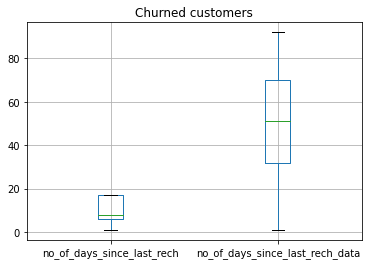

In [101]:
High_value_customers[High_value_customers['churned'] == 1][['no_of_days_since_last_rech', 'no_of_days_since_last_rech_data']].boxplot()
plt.title("Churned customers")
plt.show()

In [102]:
print("75 percentile of no_of_days_since_last_rech for Churned customers")
print(High_value_customers[High_value_customers['churned'] == 1]['no_of_days_since_last_rech'].quantile(.75))

print("75 percentile of no_of_days_since_last_rech for non-Churned customers")
print(High_value_customers[High_value_customers['churned'] == 0]['no_of_days_since_last_rech'].quantile(.75))

print("50 percentile of no_of_days_since_last_rech_data for Churned customers")
print(High_value_customers[High_value_customers['churned'] == 1]['no_of_days_since_last_rech_data'].quantile(.50))

print("50 percentile of no_of_days_since_last_rech_data for non-Churned customers")
print(High_value_customers[High_value_customers['churned'] == 0]['no_of_days_since_last_rech_data'].quantile(.50))

75 percentile of no_of_days_since_last_rech for Churned customers
17.0
75 percentile of no_of_days_since_last_rech for non-Churned customers
8.0
50 percentile of no_of_days_since_last_rech_data for Churned customers
51.0
50 percentile of no_of_days_since_last_rech_data for non-Churned customers
17.0


In [103]:
print("Average derived minute of usage for non-churned customers")
print(High_value_customers[High_value_customers['churned'] == 0][['derived_loc_og_t2f_mou', 'derived_loc_ic_t2t_mou', 'derived_loc_ic_t2m_mou']].mean())

print("Average derived minute of usage for Churned customers")
print(High_value_customers[High_value_customers['churned'] == 1][['derived_loc_og_t2f_mou', 'derived_loc_ic_t2t_mou', 'derived_loc_ic_t2m_mou']].mean())

Average derived minute of usage for non-churned customers
derived_loc_og_t2f_mou    0.225532
derived_loc_ic_t2t_mou    0.634837
derived_loc_ic_t2m_mou   -0.607157
dtype: float64
Average derived minute of usage for Churned customers
derived_loc_og_t2f_mou     0.161959
derived_loc_ic_t2t_mou     4.704278
derived_loc_ic_t2m_mou    13.158680
dtype: float64


- For Churned customer average 'derived_loc_ic_t2m_mou' = 13 means, people whose minute of usage of incoming calls from other mobile dropped by 13 units in action phase are likely to churn.
- The value of derived_loc_ic_t2t_mou can be interpreted similarly.
- For churned and non-churned derived_loc_og_t2f_mou average value is similar.

In [104]:
print("Average derived last day recharge for non-churned customers")
print(High_value_customers[High_value_customers['churned'] == 0][['derived_last_day_rch_amt']].mean())

print("Average derived last day recharge for Churned customers")
print(High_value_customers[High_value_customers['churned'] == 1][['derived_last_day_rch_amt']].mean())

Average derived last day recharge for non-churned customers
derived_last_day_rch_amt    2.970938
dtype: float64
Average derived last day recharge for Churned customers
derived_last_day_rch_amt    36.735294
dtype: float64


- 'derived_last_day_rch_amt' is obtained by subtracting last recharge amount of action phase from average last recharge amount of good phase. Higher the positive value of 'derived_last_day_rch_amt', greater the drop in recharge in action phase.
- If there is significant drop in last recharge in action phase than good phase, customers are more likely to churn. 

In [105]:
print("Average derived revenue per user for non-churned")
print(High_value_customers[High_value_customers['churned'] == 0][['derived_arpu']].mean())

print("Average derived revenue per user for Churned")
print(High_value_customers[High_value_customers['churned'] == 1][['derived_arpu']].mean())

Average derived revenue per user for non-churned
derived_arpu    5.937265
dtype: float64
Average derived revenue per user for Churned
derived_arpu    160.482711
dtype: float64


- 'derived_arpu' is obtained by subtracting arpu of action phase from average arpu of good phase. Higher the positive value of 'derived_arpu', greater the drop in revenue per user in action phase.
- If there is significant drop in revenue per use in action phase, customers are more likely to churn. 

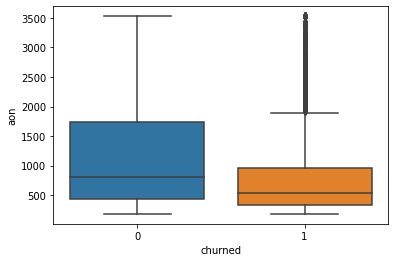

In [106]:
sns.boxplot(x=High_value_customers['churned'], y=High_value_customers['aon'])
plt.show()

In [107]:
print("Average age of network for non-churned customers")
print(High_value_customers[High_value_customers['churned'] == 0][['aon']].mean())

print("Average age of network for Churned customers")
print(High_value_customers[High_value_customers['churned'] == 1][['aon']].mean())

Average age of network for non-churned customers
aon    1183.359858
dtype: float64
Average age of network for Churned customers
aon    799.99552
dtype: float64


Relatively new customers are more likely to churn.

In [108]:
print("Non-churned Customers")
print(High_value_customers[High_value_customers["churned"] == 0]['derived_total_rech_num'].value_counts(normalize=True))

print("Churned Customers")
print(High_value_customers[High_value_customers["churned"] == 1]['derived_total_rech_num'].value_counts(normalize=True))

Non-churned Customers
 1.00     0.065154
 0.50     0.064759
 1.50     0.062349
 2.00     0.061882
 2.50     0.055697
 0.00     0.055625
-0.50     0.051383
 3.00     0.046205
-7.75     0.046133
-1.00     0.043688
 3.50     0.040092
-1.50     0.035490
 4.00     0.032541
-2.00     0.030599
 4.50     0.028262
-2.50     0.028262
 10.25    0.025781
-3.00     0.021826
 5.00     0.020531
-3.50     0.018302
 5.50     0.018194
-4.50     0.015174
-4.00     0.014994
 6.00     0.014311
-5.00     0.012549
 6.50     0.010679
 7.00     0.009780
-5.50     0.009241
 7.50     0.008702
-6.00     0.008198
-6.50     0.008018
 8.00     0.006940
 8.50     0.005717
-7.50     0.005717
-7.00     0.005645
 9.00     0.004135
 9.50     0.003811
 10.00    0.003632
Name: derived_total_rech_num, dtype: float64
Churned Customers
 10.25    0.125049
 1.00     0.059603
 3.00     0.055317
 1.50     0.050253
 2.50     0.047916
 2.00     0.047916
 0.50     0.045578
 4.50     0.044799
 3.50     0.044410
 4.00     0.039735
 5.

- Negative value of 'derived_total_rech_num' means increase of total recharge number in action phase. For retained customers, there are a lot a customers for whom total number of recharge increased.

- Positive value of 'derived_total_rech_num' means decrease in total recharge number in action phase. About 12 % of the churned customers' total number of recharge dropped by 10 in action phase. 

- This derived feature gives an comparative measure between total number of recharges in good phase and action phase, hence fraction is acceptable.

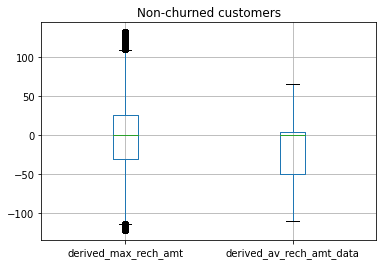

In [109]:
High_value_customers[High_value_customers['churned'] == 0][['derived_max_rech_amt', 'derived_av_rech_amt_data']].boxplot()
plt.title("Non-churned customers")
plt.show()

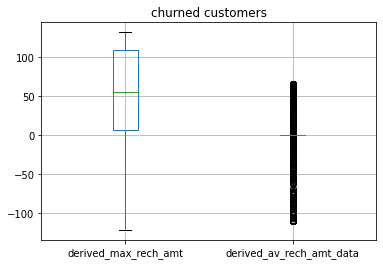

In [110]:
High_value_customers[High_value_customers['churned'] == 1][['derived_max_rech_amt', 'derived_av_rech_amt_data']].boxplot()
plt.title("churned customers")
plt.show()

Positive values of 'derived_max_rech_amt' and 'derived_av_rech_amt_data' indicate drop in maximum recharge amount and recharge data in action phase, which in turn indicates high probability of Customer churn.

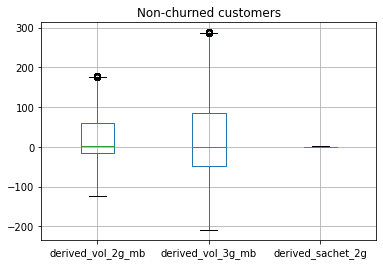

In [111]:
High_value_customers[High_value_customers['churned'] == 0][['derived_vol_2g_mb','derived_vol_3g_mb','derived_sachet_2g']].boxplot()
plt.title("Non-churned customers")
plt.show()

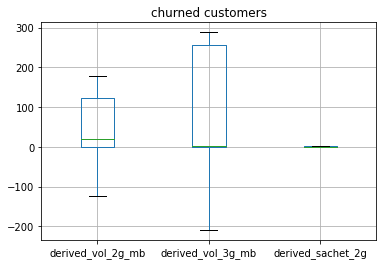

In [112]:
High_value_customers[High_value_customers['churned'] == 1][['derived_vol_2g_mb','derived_vol_3g_mb','derived_sachet_2g']].boxplot()
plt.title("churned customers")
plt.show()

High positive values of 'derived_vol_3g_mb' means for churned customers means huge drop in 3g data usage in action phase for customer who churned. 2g data is not a strong indicator for churn.

# Recommendation for Reducing Customer Churn:

### Feature Related Recommendations:

1. Customers with 'no_of_days_since_last_rech' 17 or more are most likely churn. **Sales team may focus on customers who have not made a recharge in last 17 days or more and provide them with special talk-time offers to reduce churn.**

2. Customers with 'no_of_days_since_last_rech_data' 50 or more are most likely churn. **Sales team may focus on customers who have not made a recharge for mobile data in last 1.5 months or more and provide them with special data recharge offers to reduce churn.**

3. Customers with high positive values in 'derived_loc_ic_t2m_mou' are going to churn. **Drop in incoming call usage can signify customer churn. Company needs to revise its plans and offer customers with suitable plans if incoming calls are charged. Incoming calls may reduce for poor network in customers' current location.**

4. Customers with high positive values in 'derived_last_day_rch_amt' are going to churn. **Sales team may focus on the customer whose derived_last_day_rch_amt >= 35. Drop in last recharge amount in action phase is indicator of churn.**

5. Customers with high positive values in 'derived_arpu' are going to churn. **Sales team may focus on the customer whose derived_arpu > 160. Drop in average revenue per user in action phase is important indicator of customer churn. Revenue is generated by recharges made by the customer, suitable offers can be given to the customer by checking other information such as drop in outgoing calls, drop in data recharge etc.**


6. Customers with aon (age of network) < 800 are more likely to churn than others. **Customers using the telecom operator for more than 1000 days or 3 years are proven to be loyal customers (aon>1000). Churned customers have average aon of 800, that means customers using the telecom operator for 2 years or less (800 days or less) might churn.**

7. **Positive value of 'derived_total_rech_num'> 10 is a strong indicator of churn. About 12 % of the churned customers' total number of recharge dropped by 10 in action phase. Sales team may provide customers with dropping number of recharge with suitable recharge options.** 

8. **Positive values of 'derived_max_rech_amt' and 'derived_av_rech_amt_data' indicate drop in maximum recharge amount and recharge data in action phase, which in turn indicates high probability of Customer churn.**

9. High positive values of 'derived_vol_3g_mb' means for churned customers means huge drop in 3g data usage in action phase for customer who churned. **Telecom company may need to revise its 3g data plans in order to retain customers using 3g data.**

## Conclusion

### Predictor Model
Since reducing customer churns with attractive offers is less expensive than making new customers, sensitivity score is considered for the building the final predictor model. 

Logistic Regression trained with 15 principal components has accuracy score of 0.74 and sensitivity score of 0.82 for Probability Cutoff = 0.42

- **The final model could predict 82% of the churned customers correctly out of all the churned customers. (sensitivity)**

- **Accuracy score 0.74 means 74% of the predictions made by the final model are correct out of all the predictions.**

### Interpretable Model
The top 15 features selected by RFE and manual inspection of VIF and p-values are

- 'aon' 
- 'no_of_days_since_last_rech' 
- 'no_of_days_since_last_rech_data'
- 'derived_arpu'
- 'derived_loc_og_t2f_mou'
- 'derived_loc_og_mou'
- 'derived_loc_ic_t2t_mou'
- 'derived_loc_ic_t2m_mou'
- 'derived_total_rech_num'
- 'derived_max_rech_amt'
- 'derived_last_day_rch_amt'
- 'derived_av_rech_amt_data'
- 'derived_vol_2g_mb'
- 'derived_vol_3g_mb'
- 'derived_sachet_2g'

 Logistic Regression model is built with the above features.